In [1]:
from IPython.core.display import display, HTML
import scipy.constants as sc
from scipy.optimize import fsolve
from ipywidgets import interact, widgets
%matplotlib notebook

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
import h5py

print(os.getpid())
%cd ../

7423
/media/work/docs/codes/QuCF/scripts-py


In [2]:
import pylib.mix as mix
from matplotlib import ticker
import time

path_ = "../results/LKW-1D-results/"
colors_ = ['b', 'r', 'g', 'gray', 'orange', 'black', 'magenta']

# cmap = 'seismic'
# cmap = 'bwr'
# cmap = 'jet'
# cmap = 'coolwarm'
cmap_one_sign_ = 'YlGn'
cmap_two_signs_= 'coolwarm'

def fmt_(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

class OOMFormatter(ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
            self.format = r'$\mathdefault{%s}$' % self.format

<IPython.core.display.Javascript object>


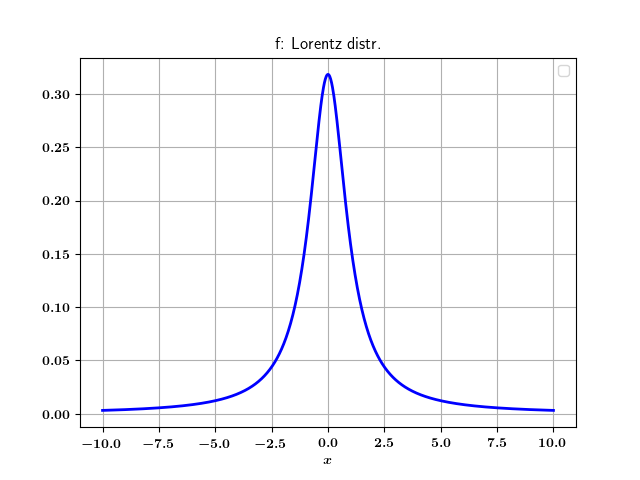

No handles with labels found to put in legend.


In [4]:
# -------------------------------------------------------------
# --- Lorentz distribution ---
# -------------------------------------------------------------
x = np.linspace(-10,10,1001)
f = lambda x: 1./np.pi * 1./(x*x+1)

fig_E = plt.figure()
ax = fig_E.add_subplot(111)
ax.plot(x, f(x), color='b', linewidth = 2, linestyle='-')
plt.xlabel('$x$')
ax.set_title("f: Lorentz distr.")
ax.legend()
plt.grid(True)
plt.show()

In [16]:
def solution_delta(w, Nx=150, Nv=100, Lx = 18, Lv = 6, x_source = 2):  
    x = np.linspace(x_source-Lx, x_source+Lx, Nx)
    v = np.linspace(-Lv,Lv,Nv)

    G = np.sqrt( 1./np.sqrt(2*np.pi) * np.exp(-v**2/2.) )

    g = np.zeros((Nx,Nv), dtype=np.complex)
    E = np.zeros(Nx, dtype=np.complex)
    for ix in range(Nx):
        x1 = x[ix]
        sh_x = x1 - x_source
        for iv in range(Nv):
            v1 = v[iv]
            k1 = w/v1

            temp = ( np.exp(1j*k1*sh_x) * np.exp(-v1**2/4.) ) / ((2*np.pi)**(1./4) * w)

            if v1 < 0:
                g[ix,iv] = temp * (np.heaviside(sh_x,1.)-1)
            if v1 > 0:
                g[ix,iv] = temp * np.heaviside(sh_x,1.)
#             g[ix,iv] = temp * np.heaviside(sh_x,1.)
        E[ix] = - np.trapz(v*G*g[ix,:])/w

    return g, E, x, v

In [35]:
def solution_gaussian(w, Nx=150, Nv=100, Lx = 18, Lv = 6, x_source = 2, d_source = 0.1): 
    x = np.linspace(x_source-Lx, x_source+Lx, Nx)
    v = np.linspace(-Lv,Lv,Nv)
    
    G = np.sqrt( 1./np.sqrt(2*np.pi) * np.exp(-v**2/2.) )
    
    g = np.zeros((Nx,Nv), dtype=np.complex)
    E = np.zeros(Nx, dtype=np.complex)

    coef_constant = np.pi**(0.25) * d_source / (2.**(0.75) * w)
    for ix in range(Nx):
        x1 = x[ix]
        shx = x1 - x_source
        for iv in range(Nv):
            v1 = v[iv]
            k1 = w / v1
            
            y1 = -1j * shx/(np.sqrt(2) * d_source) +  d_source * k1/np.sqrt(2)
            temp = coef_constant * np.exp(1j*k1*shx) * np.exp(-d_source**2 * k1**2/2.) * np.exp(-v1**2/4.)
            
            if v1 < 0:
                g[ix,iv] = temp * (1j * special.erfi(y1) - 1)
            if v1 > 0:
                g[ix,iv] = temp * (1j * special.erfi(y1) + 1) 
        E[ix] = - np.trapz(v*G*g[ix,:]) / w + np.exp(-shx**2/(2.*d_source**2)) / (1j*w)
        
    return g, E, x, v

In [29]:
# ---------------------------------------------------
# --- Analytical solution: with Delta-source ---
# ---------------------------------------------------
from scipy import special

def plot_2d(XX, YY, f, lab_x, lab_y, str_title, fsize, foom):
    fig_g = plt.figure()
    ax = fig_g.add_subplot(111)
    cs = ax.contourf(XX, YY, f, levels=100, cmap=cmap_two_signs_)
#     fig_g_analy_im.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
    cbar = fig_g.colorbar(cs, ax = ax, format=OOMFormatter(foom))
    ax.set_xlabel(lab_x, fontsize=fsize)
    ax.set_ylabel(lab_y, fontsize=fsize)
    ax.set_title(str_title, fontsize=fsize)
    ax.tick_params(axis='both', which='major', labelsize=fsize)
    cbar.ax.tick_params(axis='both', which='major', labelsize=fsize)
    cbar.ax.yaxis.get_offset_text().set_fontsize(fsize)
    
    return fig_g

# ----------------------------------------
# --- Plot an analytical solution ---
# ----------------------------------------
def plot_sol(func, foom=-1, fsize=16):
    w = 1.2
    g, E, x, v = func(w)
    XX, YY = np.meshgrid(v, x)
    
    # Re[g]
    fig_g_analy_re = plot_2d(
        XX, YY, np.real(g), 
        '$v$', '$x$', 
        '$Re[g],\quad \omega = ' + '{:0.3f}'.format(w) + "$",
        fsize, foom
    )
    
    # Im[g]
    fig_g_analy_im = plot_2d(
        XX, YY, np.imag(g), 
        '$v$', '$x$', 
        '$Im[g],\quad \omega = ' + '{:0.3f}'.format(w) + "$",
        fsize, foom
    )
      
    # E
    fig_E = plt.figure()
    ax = fig_E.add_subplot(111)
    ax.plot(x, np.real(E),       color='b', linewidth = 2, linestyle='-', label="Re[E]")
    ax.plot(x, np.imag(E),       color='r', linewidth = 2, linestyle='-', label="Im[E]")
    plt.xlabel('$x$')
    ax.set_title("E, w = {:0.3f}".format(w))
    ax.legend()
    plt.grid(True)
    plt.show()
    
    return fig_g_analy_re, fig_g_analy_im, fig_E
    
# ----------------------------------------
# --- Scan on Nx ---
# ----------------------------------------
def scan_Nx(func):
    w = 3.0
    Nxs = [250, 500, 1000, 2000]
    Es = [0]*len(Nxs)
    xs = [0]*len(Nxs)
    for ii in range(len(Nxs)):
        _, Es[ii], xs[ii], _ = func(w, Nxs[ii])
    
    # Re[E]
    fig_Er = plt.figure()
    ax = fig_Er.add_subplot(111)
    for ii in range(len(Nxs)):
        ax.plot(
            xs[ii], np.real(Es[ii]),  
            color=colors_[ii], linewidth = 2, linestyle=':', 
            label="Nx={:d}".format(Nxs[ii])
        )
    plt.xlabel('$x$')
    plt.ylabel("Re[E], w = {:0.3f}".format(w))
    ax.legend()
    plt.grid(True)
    plt.show()
    
    # Im[E]
    fig_Em = plt.figure()
    ax = fig_Em.add_subplot(111)
    for ii in range(len(Nxs)):
        ax.plot(
            xs[ii], np.imag(Es[ii]),  
            color=colors_[ii], linewidth = 2, linestyle=':', 
            label="Nx={:d}".format(Nxs[ii])
        )
    plt.xlabel('$x$')
    plt.ylabel("Im[E], w = {:0.3f}".format(w))
    ax.legend()
    plt.grid(True)
    plt.show()
    
    return fig_Er, fig_Em
    
# ----------------------------------------
# --- Scan on w ---
# ----------------------------------------
def scan_w(func, fsize=16):
    ws = [0.5, 0.75, 0.95, 1.05, 1.25, 1.50] 
    Es = [0]*len(ws)
    for ii in range(len(ws)):
        _, Es[ii], x, _ = func(ws[ii])
        
    # Re[E]
    fig_Er = plt.figure()
    ax = fig_Er.add_subplot(111)
    for ii in range(len(ws)):
        ax.plot(
            x, np.real(Es[ii]),  
            color=colors_[ii], linewidth = 2, linestyle='-', 
            label="$\omega = "+"{:0.2f}".format(ws[ii]) + "$"
        )
    plt.xlabel('$x$', fontsize=fsize)
    plt.ylabel("Re[E]", fontsize=fsize)
    ax.tick_params(axis='both', which='major', labelsize=fsize)
    ax.legend(fontsize=int(fsize*0.75))
    plt.grid(True)
    plt.show()
    
    # Im[E]
    fig_Ei = plt.figure()
    ax = fig_Ei.add_subplot(111)
    for ii in range(len(ws)):
        ax.plot(
            x, np.imag(Es[ii]),  
            color=colors_[ii], linewidth = 2, linestyle='-', 
            label="$\omega = "+"{:0.2f}".format(ws[ii]) + "$"
        )
    plt.xlabel('$x$', fontsize=fsize)
    plt.ylabel("Im[E]", fontsize=fsize)
    ax.tick_params(axis='both', which='major', labelsize=fsize)
    ax.legend(fontsize=int(fsize*0.75))
    plt.grid(True)
    plt.show()
    
    return fig_Er, fig_Ei

<IPython.core.display.Javascript object>


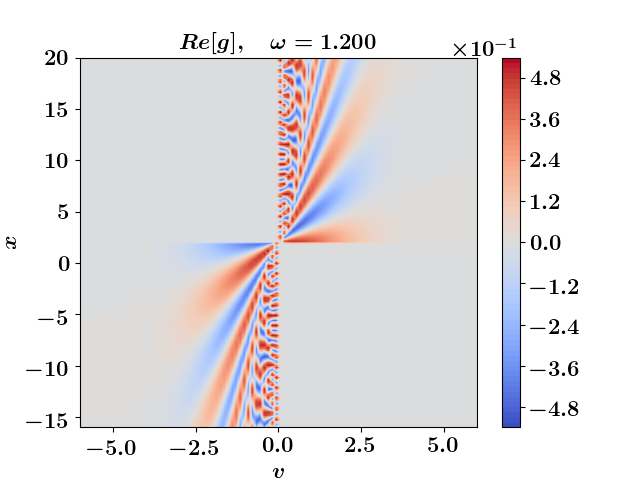

<IPython.core.display.Javascript object>


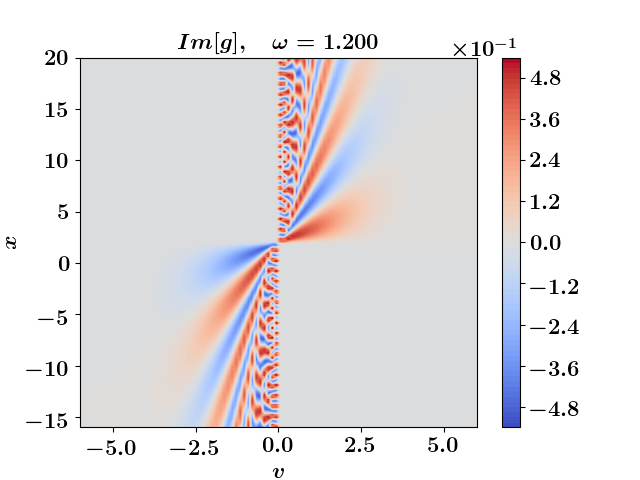

<IPython.core.display.Javascript object>


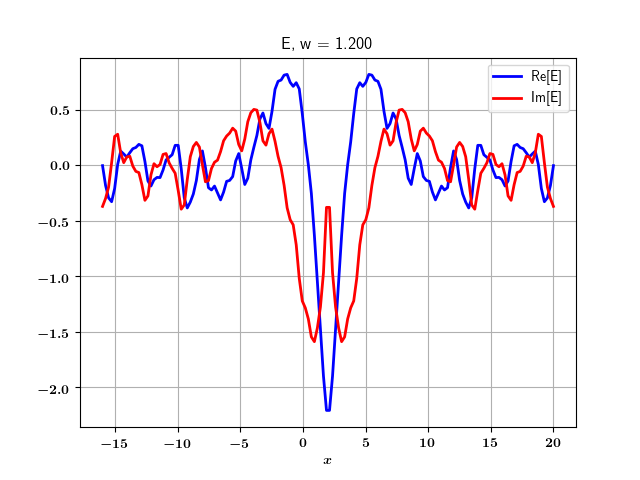

<IPython.core.display.Javascript object>


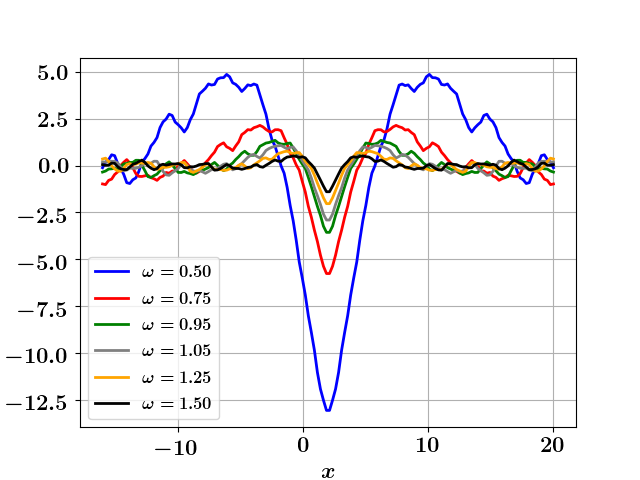

<IPython.core.display.Javascript object>


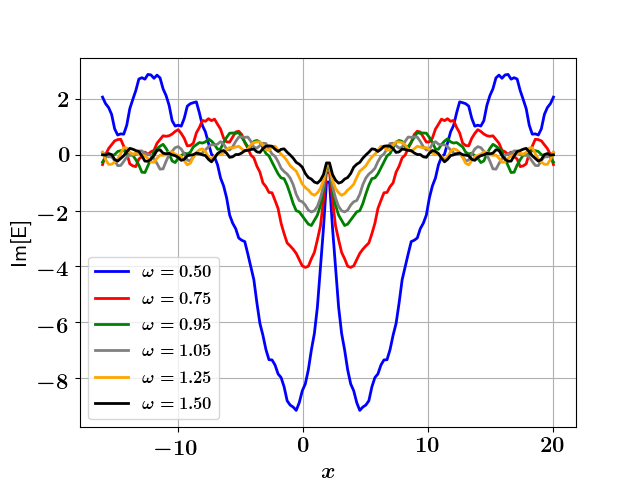

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [31]:
# ----------------------------------------------------------------
# --- Solution of the case with Delta-source ---
# ----------------------------------------------------------------
fig_g_analy_re, fig_g_analy_im, _ = plot_sol(solution_delta, foom=-1)
fig_Er_scan_w, fig_Ei_scan_w = scan_w(solution_delta)

fig_g_analy_re.savefig(
    '/media/work/docs/codes/QuCF/results/LKW-1D-results/analytics-Delta/' + "/gr_delta.eps"
)
fig_g_analy_im.savefig(
    '/media/work/docs/codes/QuCF/results/LKW-1D-results/analytics-Delta/' + "/gi_delta.eps"
)
fig_Er_scan_w.savefig(
    '/media/work/docs/codes/QuCF/results/LKW-1D-results/analytics-Delta/' + "/Er_scan_w_delta.eps"
)
fig_Ei_scan_w.savefig(
    '/media/work/docs/codes/QuCF/results/LKW-1D-results/analytics-Delta/' + "/Ei_scan_w_delta.eps"
)

del fig_g_analy_re, fig_g_analy_im, fig_Er_scan_w, fig_Ei_scan_w

<IPython.core.display.Javascript object>


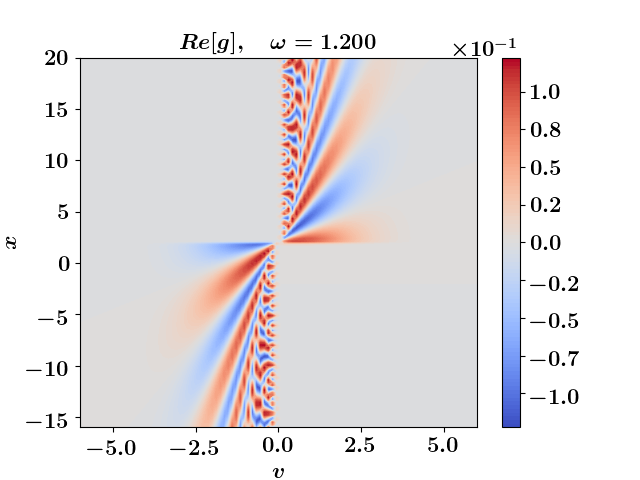

<IPython.core.display.Javascript object>


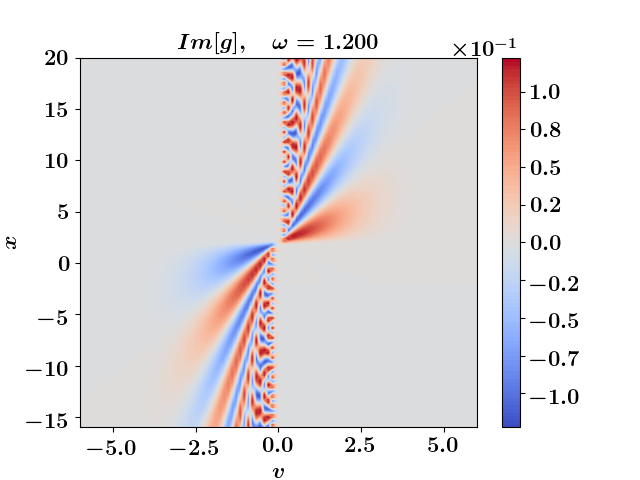

<IPython.core.display.Javascript object>


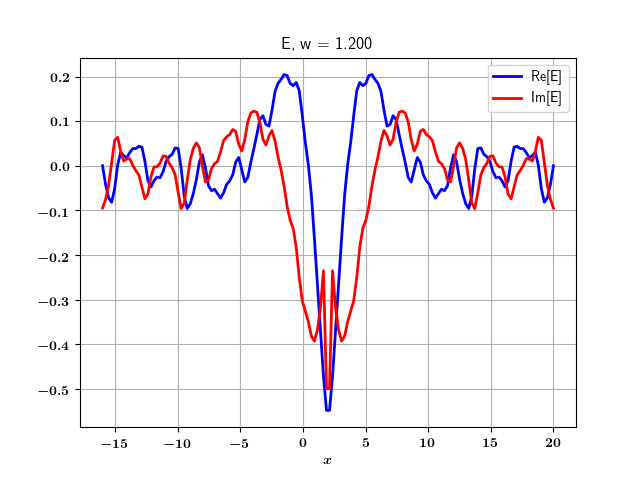

<IPython.core.display.Javascript object>


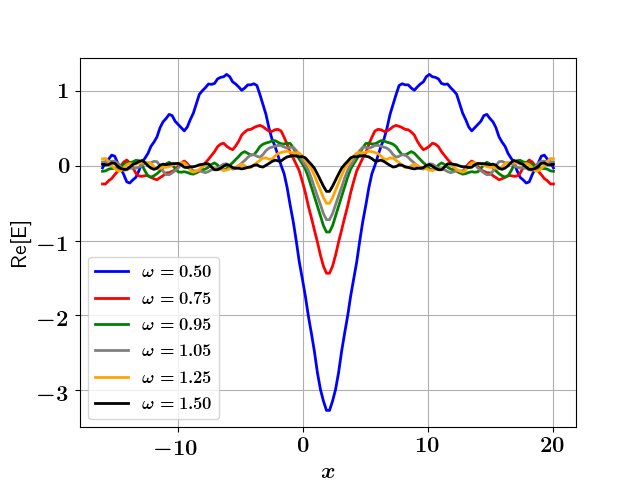

<IPython.core.display.Javascript object>


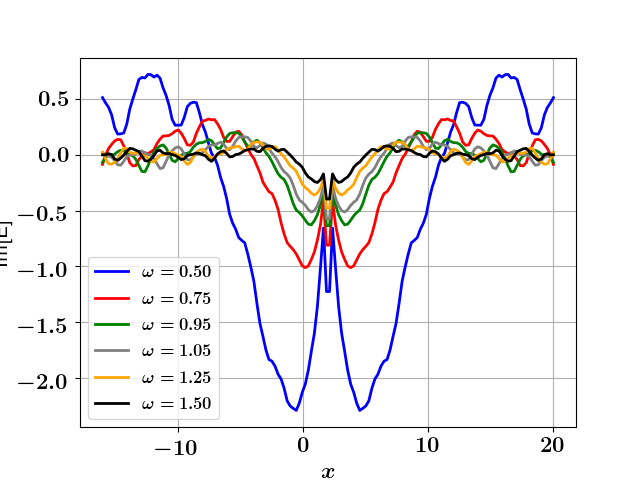

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [37]:
# ----------------------------------------------------------------
# --- Solution of the case with Gaussian-source ---
# ----------------------------------------------------------------
fig_g_analy_re, fig_g_analy_im, _ = plot_sol(solution_gaussian, foom=-1)
fig_Er_scan_w, fig_Ei_scan_w = scan_w(solution_gaussian)

fig_g_analy_re.savefig(
    '/media/work/docs/codes/QuCF/results/LKW-1D-results/analytics-Delta/' + "/gr_gauss.eps"
)
fig_g_analy_im.savefig(
    '/media/work/docs/codes/QuCF/results/LKW-1D-results/analytics-Delta/' + "/gi_gauss.eps"
)
fig_Er_scan_w.savefig(
    '/media/work/docs/codes/QuCF/results/LKW-1D-results/analytics-Delta/' + "/Er_scan_w_gauss.eps"
)
fig_Ei_scan_w.savefig(
    '/media/work/docs/codes/QuCF/results/LKW-1D-results/analytics-Delta/' + "/Ei_scan_w_gauss.eps"
)

del fig_g_analy_re, fig_g_analy_im, fig_Er_scan_w, fig_Ei_scan_w